<a href="https://colab.research.google.com/github/pablo-arantes/ParametrizANI/blob/main/Psi4%2BTorchANI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ParametrizANI - Dihedral Parametrization in the Cloud with TorchANI**

This is a Jupyter notebook to set up a protocol to calculate a reference dihedral potential with Psi4 and TorchANI (structural optimization), a PyTorch-based program for training/inference of ANI (ANAKIN-ME) deep learning models to obtain potential energy surfaces and other physical properties of molecular systems.  TorchANI is open-source and freely available on GitHub: https://github.com/aiqm/torchani.

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to parametrize compounds in a cheap and yet feasible fashion.

---

 **This notebook is NOT a standard protocol for parametrization!** It is just simple parametrization pipeline illustrating each step of a protocol.

--- 
**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/ParametrizANI/issues

**Acknowledgments**
- We would like to thank the [Psi4](https://psicode.org/) team for developing an excellent and open source suite of ab initio quantum chemistry.

- We would like to thank the [Roitberg](https://roitberg.chem.ufl.edu/) team for developing the fantastic [TorchANI](https://github.com/aiqm/torchani).

- We would like to thank the [Xavier Barril](http://www.ub.edu/bl/) team for their protocol on dihedrals parametrization and for the genetic algorithm script.

- We would like to thank [iwatobipen](https://twitter.com/iwatobipen) for his fantastic [blog](https://iwatobipen.wordpress.com/) on chemoinformatics.

- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.


- Finally, we would like to thank [Making it rain](https://github.com/pablo-arantes/making-it-rain) team, **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)), for their amazing work.

- For related notebooks see: https://github.com/pablo-arantes/ParametrizANI

# **Overview:**

**1.** Create the conformers for each dihedral angle.

**2.** Perform structural optimization, of each conformer, with TorchANI.

**3.** Calculate reference curve with Psi4.

# **Setting the environment for the calculation**

Firstly, we need to install all necessary libraries and packages for our protocol. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    Psi4 (https://psicode.org/)
3.    RDKit (https://www.rdkit.org/)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    TorchANI (https://aiqm.github.io/torchani/)

In [1]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [1]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture
!pip install py3Dmol
!mamba install -c anaconda intel-openmp
!mamba install -c psi4 psi4 resp
!mamba install pytorch torchvision -c pytorch
!pip install torchani
!pip install ase
!pip install rdkit-pypi
!mamba install -c conda-forge debtcollector
!pip install git+https://github.com/pablo-arantes/psikit
!mamba install -c conda-forge openbabel -y

Smiles: O=C(OCCO)c1ccc(C(=O)OCCO)cc1


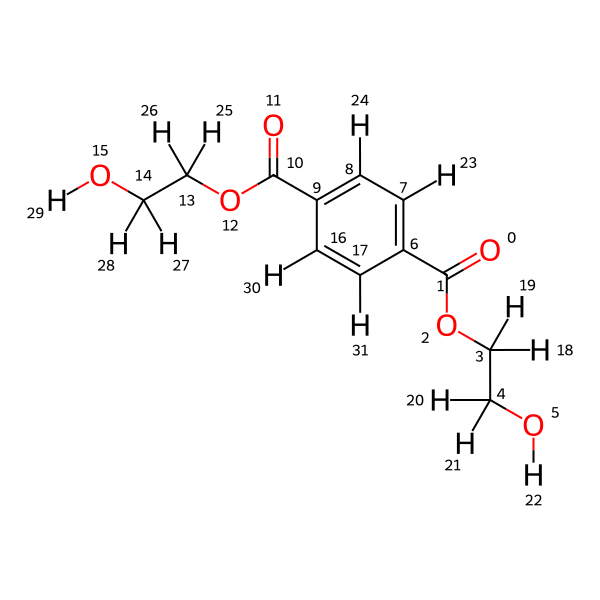

In [2]:
#@title **Please, provide the necessary information for the molecule**: 

#@markdown Type the smiles or filename (PDB and MOL formats) of your molecule. **Ex: C=CC(=O)OC, molecule.pdb or molecule.mol** 

#@markdown Just remind you that if you want to use pdb or mol file, you should first upload the file here in Colab.

#@markdown If you don't know the exactly smiles, please, check at https://pubchem.ncbi.nlm.nih.gov/
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from openbabel import pybel
import os

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

import py3Dmol


workDir = "/content/"
Type = "smiles" #@param ["smiles", "pdb", "mol"]

smiles_or_filename = 'O=C(OCCO)c1ccc(C(=O)OCCO)cc1' #@param {type:"string"}

if Type == "smiles":
  Smiles = smiles_or_filename 
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
elif Type == "pdb":
  mol= [m for m in pybel.readfile(filename=smiles_or_filename, format='pdb')][0]
  out=pybel.Outputfile(filename='mol.mol',format='mol',overwrite=True)
  out.write(mol)
  out.close()
  mol = Chem.MolFromMolFile('mol.mol')
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
else:
  mol = Chem.MolFromMolFile(smiles_or_filename)
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)


d2d = rdMolDraw2D.MolDraw2DSVG(600, 600)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(hmol)
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
with open('smiles.svg', 'w') as f:
    f.write(svg)
print("Smiles: " + str(Smiles))
SVG(svg)

In [ ]:
#@title ### **Set your dihedral angle**
#@markdown Type the number of atoms for your dihedral angle.
#@markdown The dihedral angle we will perform the dihedral scan will be defined by these atoms.
from termcolor import colored

atom1 = '0' #@param {type:"string"}
atom2 = '1' #@param {type:"string"}
atom3 = '2' #@param {type:"string"}
atom4 = '3' #@param {type:"string"}

#@markdown Select step size in degrees for the dihedral angle rotation:
degrees_steps = "30" #@param ["10", "15", "20", "30", "45", "60"]
with open('degrees.dat', 'w') as f:
  f.write(degrees_steps)

optimization = "MMFF94" #@param ["ANI", "MMFF94"]

if optimization == "MMFF94":
  mol = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(hmol)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  AllChem.OptimizeMolecule(ff, maxIters=1000)
  ff.Minimize()
  charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Chem.GetFormalCharge(hmol)
  print("Charge = " + str(charge))
  if not charge == 0:
    print(colored("ANI cannot do charged system yet, stay tuned!", 'red'))
    exit()
  else:
    pass
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)
else:
  from typing import List
  from ase import Atoms
  from ase.lattice.cubic import Diamond
  from ase.md.langevin import Langevin
  from ase.optimize import BFGS
  from ase import io
  from ase.io import read, write
  from ase import units
  from ase.constraints import ExternalForce, FixInternals
  import torch
  import torchani
  import pandas as pd
  import numpy as np
  from torchani.units import HARTREE_TO_KCALMOL
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")


  def mol2arr(mols, device=device):
      coordinates = []
      spices = []
      for mol in mols:
          pos = mol.GetConformer().GetPositions().tolist()
          atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
          coordinates.append(pos)
          spices.append(atomnums)
      coordinates = torch.tensor(coordinates, requires_grad=True, device=device)
      species = torch.tensor(spices, device=device)
      return coordinates, species

  mol = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(hmol)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  AllChem.OptimizeMolecule(ff, maxIters=1000)
  ff.Minimize()
  charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Chem.GetFormalCharge(hmol)
  print("Charge = " + str(charge))
  if not charge == 0:
    print(colored("ANI cannot do charged system yet, stay tuned!", 'red'))
    exit()
  else:
    pass
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, f"start.mol")))
  mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, f"start.mol")), removeHs=False)
  mol = io.read(os.path.join(workDir, f"start.mol"))
  coordinates, species = mol2arr([mol_deg], device)
  tensor1 = coordinates.detach().numpy()
  atoms = Atoms(mol, positions=tensor1[0])
  atoms.center(vacuum=3.0)
  atoms.set_calculator(calculator)
  print("Begin minimizing ")
  opt = BFGS(atoms)
  opt.run(fmax=0.0001)
  write((os.path.join(workDir, f"start_min.xyz")), format="xyz", images=atoms)

  atomic_symbols = []
  xyz_coordinates = []

  with open((os.path.join(workDir, f"start_min.xyz")), "r") as file:
    for line_number,line in enumerate(file):
      if line_number == 0:
        num_atoms = int(line)
      elif line_number == 1:
        comment = line # might have useful information
      else:
        atomic_symbol, x, y, z = line.split()
        atomic_symbols.append(atomic_symbol)
        xyz_coordinates.append([float(x),float(y),float(z)])

  from rdkit.Geometry import Point3D
  conf = mol_deg.GetConformer()

  for i in range(mol_deg.GetNumAtoms()):
    x,y,z = xyz_coordinates[i]
    conf.SetAtomPosition(i,Point3D(x,y,z))
  AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, f"start_min.mol")))


  hmol = AllChem.MolFromMolFile ((os.path.join(workDir, f"start_min.mol")), removeHs=False)
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)

In [ ]:
#@title ### **Create the conformers based on your dihedral angle**
#@markdown Run this cell to create the conformers based on your selections from previous cell. To do so, we will rotate the dihedral from -180 to 180 degrees (with a step size chosen in the previous cell).

#@markdown **Important**: The output will show just a few conformers, not all of them. If you check the **mol_files** folder, all of your conformers will be there.


#Create the conformers and save in the folder
import glob
import copy
import numpy as np
from IPython.display import display

if os.path.exists(os.path.join(workDir, "mol_files")):
  for f in glob.glob(os.path.join(workDir, "mol_files/*.mol")):
    os.remove(f)
else:
  os.mkdir(os.path.join(workDir, "mol_files"))

confs = []
filenames = []

if optimization == "ANI":
  hmol = AllChem.MolFromMolFile ((os.path.join(workDir, f"start_min.mol")), removeHs=False)
else:
  pass

for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
    rdMolTransforms.SetDihedralDeg(hmol.GetConformer(0), int(atom1), int(atom2), int(atom3), int(atom4), deg)
    mp = AllChem.MMFFGetMoleculeProperties(hmol)
    ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
    ff.MMFFAddTorsionConstraint(int(atom1), int(atom2), int(atom3), int(atom4), False, deg, deg, 1000.0,)
    # for a in hmol.GetAtoms():
    #     if (a.GetAtomicNum() > 1):
    #         ff.MMFFAddPositionConstraint(a.GetIdx(), 0.0, 1.e4)
    AllChem.OptimizeMolecule(ff, maxIters=200)
    ff.Minimize(maxIts=1000)
    AllChem.MolToMolFile(hmol, (os.path.join(workDir, "mol_files/" + str(deg) + ".mol")))
    if deg % 90 == 0:
        print(deg)
        display(IPythonConsole.drawMol3D(hmol))

In [6]:
#@title **Geometry optimization of conformers with TorchANI**: 

#@markdown Please, select your ANI model:
model_name = "ANI-2x" #@param ["ANI-1x", "ANI-1ccx", "ANI-2x"]

#@markdown Convergence threshold for geometry optimization:

opt_tol = 0.0001 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}

from typing import List
from ase import Atoms
from ase.lattice.cubic import Diamond
from ase.md.langevin import Langevin
from ase.optimize import BFGS
from ase import io
from ase.io import read, write
from ase import units
from ase.constraints import ExternalForce, FixInternals
from ase.calculators.psi4 import Psi4
from ase.build import molecule
import torch
import torchani
import pandas as pd
import numpy as np
from torchani.units import HARTREE_TO_KCALMOL

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

if model_name == "ANI-2x":
  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")
elif model_name == "ANI-1ccx":
  model = torchani.models.ANI1ccx(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1ccx().ase()
  print("Model = ANI1ccx")
elif model_name == "ANI-1x":
  model = torchani.models.ANI1x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1x().ase()
  print("Model = ANI1x")
else:
  pass

def mol2arr(mols, device=device):
    coordinates = []
    spices = []
    for mol in mols:
        pos = mol.GetConformer().GetPositions().tolist()
        atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
        coordinates.append(pos)
        spices.append(atomnums)
    coordinates = torch.tensor(coordinates,
                               requires_grad=True,
                               device=device)
    species = torch.tensor(spices, device=device)
    return coordinates, species


for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "mol_files/" + str(deg) + ".mol")), removeHs=False)
  mol = io.read(os.path.join(workDir, "mol_files/" + str(deg) + ".mol"))
  coordinates, species = mol2arr([mol_deg], device)
  tensor1 = coordinates.detach().numpy()
  atoms = Atoms(mol, positions=tensor1[0])
  atoms.center(vacuum=3.0)
  dihedral_indices1 = [int(atom1), int(atom2), int(atom3), int(atom4)]
  dihedral1 = [atoms.get_dihedral(*dihedral_indices1), dihedral_indices1]
  c = FixInternals(dihedrals_deg=[dihedral1])
  atoms.set_constraint(c)
  atoms.set_calculator(calculator)
  print("Begin minimizing " + str(deg) + ".mol" )
  opt = BFGS(atoms)
  opt.run(fmax=opt_tol)
  write((os.path.join(workDir, "mol_files/" + str(deg) + "_min.xyz")), format="xyz", images=atoms)

  atomic_symbols = []
  xyz_coordinates = []

  with open((os.path.join(workDir, "mol_files/" + str(deg) + "_min.xyz")), "r") as file:
    for line_number,line in enumerate(file):
        if line_number == 0:
            num_atoms = int(line)
        elif line_number == 1:
            comment = line # might have useful information
        else:
            atomic_symbol, x, y, z = line.split()
            atomic_symbols.append(atomic_symbol)
            xyz_coordinates.append([float(x),float(y),float(z)])

  from rdkit.Geometry import Point3D
  conf = mol_deg.GetConformer()

  for i in range(mol_deg.GetNumAtoms()):
    x,y,z = xyz_coordinates[i]
    conf.SetAtomPosition(i,Point3D(x,y,z))
  AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, "mol_files/" + str(deg) + "_min.mol")))
  AllChem.MolToPDBFile(mol_deg, (os.path.join(workDir, "mol_files/" + str(deg) + "_min.pdb")))

Model = ANI2x
Begin minimizing -180.mol
      Step     Time          Energy         fmax
BFGS:    0 20:23:59   -24947.205531        1.8717


/usr/local/lib/python3.8/site-packages/torchani/ase.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525491394/work/torch/csrc/utils/tensor_new.cpp:230.)
  cell = torch.tensor(self.atoms.get_cell(complete=True),


BFGS:    1 20:23:59   -24947.264002        2.8040
BFGS:    2 20:23:59   -24947.337760        0.5508
BFGS:    3 20:24:00   -24947.364217        0.4282
BFGS:    4 20:24:00   -24947.385060        0.5883
BFGS:    5 20:24:00   -24947.399646        0.4893
BFGS:    6 20:24:00   -24947.409536        0.3103
BFGS:    7 20:24:00   -24947.415747        0.1926
BFGS:    8 20:24:00   -24947.421244        0.1446
BFGS:    9 20:24:01   -24947.425048        0.1301
BFGS:   10 20:24:01   -24947.427985        0.1262
BFGS:   11 20:24:01   -24947.431270        0.1491
BFGS:   12 20:24:01   -24947.435548        0.1664
BFGS:   13 20:24:01   -24947.440280        0.1455
BFGS:   14 20:24:01   -24947.444825        0.1429
BFGS:   15 20:24:01   -24947.449155        0.1147
BFGS:   16 20:24:02   -24947.453542        0.1437
BFGS:   17 20:24:02   -24947.457685        0.1390
BFGS:   18 20:24:02   -24947.460977        0.1273
BFGS:   19 20:24:02   -24947.463342        0.1041
BFGS:   20 20:24:02   -24947.465487        0.0938


In [7]:
#@title **Dihedral scan energy profile with Psi4**: 

#@markdown Please, select your method and basis set:

method = "MP2" #@param ["B3LYP", "MP2", "HF"]

basisSet = "6-31G*" #@param ["STO-3g", "3-21G", "6-31G*", "6-31G**", "6-31+G(d,p)", "6-311++G(2d,p)"]

from psikit import Psikit
pk = Psikit()


def B3LYP_basis (basis_Set):
    vals = {"STO-3g" : "b3lyp/STO-3g"  ,  "3-21G" : "b3lyp/3-21G", "6-31G*" : "b3lyp/6-31g*", "6-31G**" : "b3lyp/6-31g**", "6-31+G(d,p)" : "b3lyp/6-31+G(d,p)", "6-311++G(2d,p)" : "b3lyp/6-311++G(2d,p)" }
    return vals[basis_Set]

def MP2_basis (basis_Set):
    vals = {"STO-3g" : "mp2/STO-3g"  ,  "3-21G" : "mp2/3-21G", "6-31G*" : "mp2/6-31g*", "6-31G**" : "mp2/6-31g**", "6-31+G(d,p)" : "mp2/6-31+G(d,p)", "6-311++G(2d,p)" : "mp2/6-311++G(2d,p)" }
    return vals[basis_Set]

def HF_basis (basis_Set):
    vals = {"STO-3g" : "hf/STO-3g"  ,  "3-21G" : "hf/3-21G", "6-31G*" : "hf/6-31g*", "6-31G**" : "hf/6-31g**", "6-31+G(d,p)" : "hf/6-31+G(d,p)", "6-311++G(2d,p)" : "hf/6-311++G(2d,p)" }
    return vals[basis_Set]

if method == "B3LYP":
  basis_set_psi4 = B3LYP_basis(basisSet)
elif method == "MP2":
  basis_set_psi4 = MP2_basis(basisSet)
elif method == "HF":
  basis_set_psi4 = HF_basis(basisSet)
else:
  pass

print("Degrees    Energy")

dihedral_energies = []
dihe_degree = []
for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  pk.read_from_molfile(os.path.join(workDir, "mol_files/" + str(deg) + "_min.mol"), opt=False)
  degy = pk.energy(basis_sets=basis_set_psi4)
  print(deg, degy)
  dihedral_energies.append(degy)
  dihe_degree.append(deg)

dihedral_energies_array = np.array(dihedral_energies)
relative = (dihedral_energies_array - dihedral_energies_array.min()) * pk.psi4.constants.hartree2kcalmol

#Save dat file
with open(str(method) + "_" + str(basisSet) + '.dat', 'w') as f:
    for deg, item in zip(dihe_degree, relative):
      degree_str = str("{:.3f}".format(deg))
      energy_str = str("{:.3f}".format(item))
      f.write(str(deg) + " " + str(item) + "\n")
      # f.write("%s\n" % item)

Degrees    Energy
-180 -914.3955503770613
-150 -914.3981027726197
-120 -914.4026675956286
-90 -914.4050083268165
-60 -914.4098959712554
-30 -914.4186899249462
0 -914.4214553453908
30 -914.4148347973189
60 -914.4080355871428
90 -914.4045752352416
120 -914.4033685537138
150 -914.4026766796046
180 -914.4020146422667


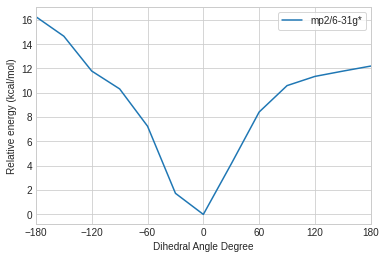

In [8]:
#@title **Check the profile calculated with Psi4**: 

#@markdown y-axis with energy in kcal/mol and x-axis with dihedral angle degrees.

import numpy as np
dihedral_energies_array = np.array(dihedral_energies)
 
relative = (dihedral_energies_array - dihedral_energies_array.min()) * pk.psi4.constants.hartree2kcalmol
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

plt.plot(dihe_degree, relative, linewidth = 1.5, label = basis_set_psi4)
# ani = pd.read_csv('/content/ani.dat', header=None)
# plt.plot(dihe_degree, ani, linewidth = 1.5, label = "ANI")
plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([-180, 180])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
plt.savefig(str(method) + "_" + str(basisSet) + '.png', dpi=600, bbox_inches='tight')

In [ ]:
#@title **Download your results**
from google.colab import files

if os.path.exists("dihedral_scan.zip"):
  os.remove("dihedral_scan.zip")
else:
  pass

!zip -FSr "dihedral_scan.zip" "mol_files" "pdb_min" *".pdb" *".png" *."txt" *."dat" *."svg"  >/dev/null 2>&1
files.download('dihedral_scan.zip')